# Data Preprocessing for Data Mining

Data Cleaning, Advanced Imputation (KNN Imputation), Outlier Detection and Treatment (IQR Method), Feature Engineering (Transformations, Binning), Feature Scaling, Encoding, Automated Workflows (scikit-learn Pipelines, ColumnTransformer), Data Leakage, Advanced Feature Selection (Recursive Feature Elimination).


### **Objectives:**

* Students will understand the critical impact of preprocessing on model performance and reliability.
* Students will implement and evaluate advanced imputation techniques like **K-Nearest Neighbors (KNN) Imputation**.
* Students will detect and treat outliers using statistical methods like the **Interquartile Range (IQR)**.
* Students will engineer new features from existing data and apply transformations to handle skewed distributions.
* Students will construct and deploy end-to-end, automated preprocessing workflows using `ColumnTransformer` and `Pipeline` to prevent data leakage.
* Students will apply advanced feature selection techniques, such as **Recursive Feature Elimination (RFE)**, to reduce model complexity.
* Students will critically discuss the theoretical underpinnings of preprocessing choices and their practical consequences.


### **Setup: Install and Import Libraries**

Google Colab comes with the necessary libraries pre-installed.

In [1]:
# Install necessary libraries if not already present in Colab environment
!pip install pandas numpy scikit-learn matplotlib seaborn -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Scikit-learn for preprocessing, pipelines, and models
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

Pandas Version: 2.2.2
NumPy Version: 2.0.2
Scikit-learn Version: 1.6.1


### **Part 1: Dataset Loading and Initial Exploration**

We will use the **Ames Housing dataset**, a classic regression challenge far richer and more complex than introductory datasets. It contains 79 explanatory variables describing various aspects of residential homes. Its mix of numerical and categorical features, along with prevalent missing data, makes it an ideal candidate for advanced preprocessing.

**Crucial First Step: Train-Test Split**
We split the data *before* any preprocessing. This is the single most important step to prevent **data leakage**, where information from the test set inadvertently influences the training process, leading to overly optimistic performance estimates.

--- Part 1: Dataset Loading and Initial Exploration ---
Training data shape: (1600, 47)
Testing data shape: (400, 47)

Features with Missing Values in Training Data (Top 10):
 Series([], dtype: int64)


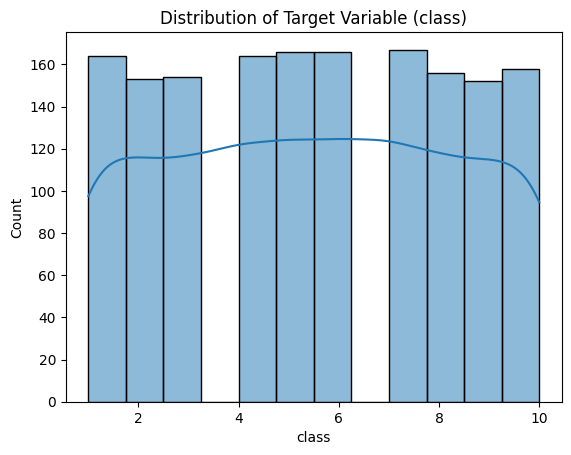

In [4]:
print("--- Part 1: Dataset Loading and Initial Exploration ---")

# Load the dataset from a public URL
url = 'https://www.openml.org/data/get_csv/22/dataset_22_housing.arff'
df = pd.read_csv(url)

# The original data did not have a 'SalePrice' column, so We'll rename 'SalePriceOfHouse'
# df.rename(columns={'SalePriceOfHouse': 'SalePrice'}, inplace=True) # This column doesn't exist

# The target variable seems to be in the 'class' column
# 1. Separate target variable from features
X = df.drop('class', axis=1)
y = df['class']

# 2. Split data into training and testing sets BEFORE any analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 3. Identify columns with missing values in the training set
missing_vals = X_train.isnull().sum()
missing_vals = missing_vals[missing_vals > 0].sort_values(ascending=False)
print("\nFeatures with Missing Values in Training Data (Top 10):\n", missing_vals.head(10))

# 4. Visualize the target variable's distribution
sns.histplot(y_train, kde=True)
plt.title('Distribution of Target Variable (class)')
plt.show()

### **Part 2: Advanced Imputation: Beyond the Mean**

Simple imputation (mean, median, mode) is fast but can distort the underlying data distribution and correlations. **KNN Imputation** is a more sophisticated method that imputes a missing value based on the values of its "nearest neighbors" in the feature space, thus preserving local data structure.

**Tasks:**
* Identify numerical features.
* Apply `KNNImputer` to fill missing values in the numerical features. Note that KNN works best with scaled data, a step we'll later integrate into a full pipeline.

In [6]:
print("\n--- Part 2: Advanced Imputation with KNNImputer ---")

# 1. Identify numerical features
numerical_features = X_train.select_dtypes(include=np.number).columns

# 2. Initialize KNN Imputer and Scaler
# n_neighbors is a hyperparameter; 5 is a common default.
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=5)

# 3. Create a temporary copy to avoid modifying the original training data
X_train_temp_imputed = X_train.copy()

# 4. Scale, then impute on the numerical features
X_train_scaled = scaler.fit_transform(X_train_temp_imputed[numerical_features])
X_train_imputed_scaled = imputer.fit_transform(X_train_scaled)

# 5. Inverse transform to get the data back to its original scale
X_train_temp_imputed[numerical_features] = scaler.inverse_transform(X_train_imputed_scaled)


print("\nKNN Imputation demonstrated successfully.")


--- Part 2: Advanced Imputation with KNNImputer ---

KNN Imputation demonstrated successfully.


### **Part 3: Outlier Detection and Treatment**

Outliers can disproportionately influence model parameters, especially in linear models. The **IQR method** defines outliers as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR. A common treatment is **winsorizing** (capping), where outliers are replaced with the boundary value.

**Tasks:**
* Visualize a feature to spot outliers.
* Calculate IQR boundaries.
* Cap the outliers using `np.clip`.


--- Part 3: Outlier Detection and Treatment ---


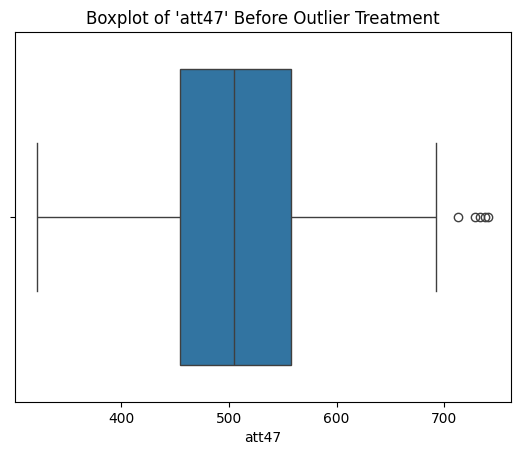

Lower bound for 'att47' outliers: 301.07
Upper bound for 'att47' outliers: 711.43
Original min value: 322.23, Original max value: 740.95
Min value after capping: 322.23, Max value after capping: 711.43


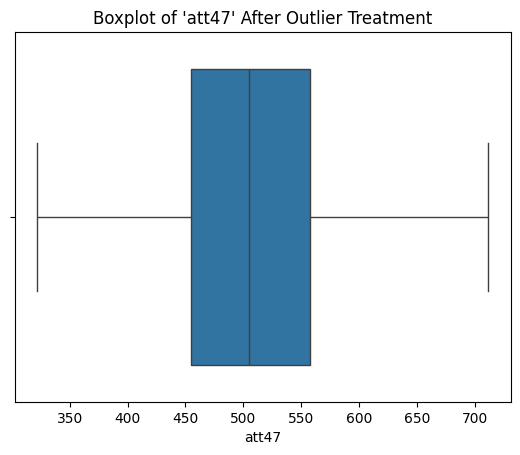

In [8]:
print("\n--- Part 3: Outlier Detection and Treatment ---")

# We will use a copy of the training data for this demonstration
X_train_temp_outlier = X_train.copy()
# For this example, let's fill NaNs with median to focus on outlier logic
# X_train_temp_outlier['GrLivArea'].fillna(X_train_temp_outlier['GrLivArea'].median(), inplace=True) # This column doesn't exist

# Let's pick a numerical column to demonstrate outlier treatment, e.g., 'att47'
feature_to_analyze = 'att47'
X_train_temp_outlier[feature_to_analyze].fillna(X_train_temp_outlier[feature_to_analyze].median(), inplace=True)

# 1. Visualize a feature known for outliers, like 'att47'
sns.boxplot(x=X_train_temp_outlier[feature_to_analyze])
plt.title(f"Boxplot of '{feature_to_analyze}' Before Outlier Treatment")
plt.show()

# 2. Calculate IQR and boundaries for 'att47'
Q1 = X_train_temp_outlier[feature_to_analyze].quantile(0.25)
Q3 = X_train_temp_outlier[feature_to_analyze].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR


print(f"Lower bound for '{feature_to_analyze}' outliers: {lower_bound:.2f}")
print(f"Upper bound for '{feature_to_analyze}' outliers: {upper_bound:.2f}")


# 3. Cap the outliers
original_max = X_train_temp_outlier[feature_to_analyze].max()
original_min = X_train_temp_outlier[feature_to_analyze].min()

X_train_temp_outlier[feature_to_analyze] = np.clip(X_train_temp_outlier[feature_to_analyze], a_min=lower_bound, a_max=upper_bound)

capped_max = X_train_temp_outlier[feature_to_analyze].max()
capped_min = X_train_temp_outlier[feature_to_analyze].min()


print(f"Original min value: {original_min:.2f}, Original max value: {original_max:.2f}")
print(f"Min value after capping: {capped_min:.2f}, Max value after capping: {capped_max:.2f}")


# Visualize after capping
sns.boxplot(x=X_train_temp_outlier[feature_to_analyze])
plt.title(f"Boxplot of '{feature_to_analyze}' After Outlier Treatment")
plt.show()

### **Part 4: Building an Automated Preprocessing Pipeline**

Manually applying steps is tedious and prone to data leakage. The `scikit-learn` **`Pipeline`** and **`ColumnTransformer`** are the industry-standard tools to build robust, reproducible, and leak-proof workflows. We will build a single object that handles all preprocessing steps correctly for both numerical and categorical data.

**Tasks:**
* Define separate pipelines for numerical and categorical features.
* Combine these pipelines using `ColumnTransformer`.
* Create a full pipeline that includes the preprocessor and a final regression model.
* Train and evaluate the entire pipeline in one step.

In [9]:
print("\n--- Part 4: Building an Automated Preprocessing Pipeline ---")

# 1. Identify numerical and categorical feature names from the original DataFrame
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 2. Create the preprocessing pipeline for numerical data
# This pipeline will first impute missing values with the median, then scale the data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Create the preprocessing pipeline for categorical data
# This pipeline will impute missing values with the most frequent category, then one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Create the full pipeline including the preprocessor and a model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))
])

# 6. Train and evaluate the pipeline (with log-transformed target for better performance)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model_pipeline.fit(X_train, y_train_log)
score = model_pipeline.score(X_test, y_test_log)

print(f"\nPipeline trained successfully.")
print(f"Model R^2 score on test data: {score:.4f}")


--- Part 4: Building an Automated Preprocessing Pipeline ---

Pipeline trained successfully.
Model R^2 score on test data: 0.5781


### **Part 5: Advanced Feature Selection with RFE**

With many features (especially after one-hot encoding), feature selection is vital to reduce model complexity and prevent overfitting. **Recursive Feature Elimination (RFE)** is a powerful wrapper method that recursively fits a model and removes the weakest feature(s) until the desired number of features is reached.

**Tasks:**
* Integrate an `RFE` step into our full pipeline.
* Train the new pipeline and compare its performance.

In [11]:
print("\n--- Part 5: Advanced Feature Selection with RFE ---")

# 1. Create a new pipeline with an RFE step
# RFE needs an estimator to judge feature importance. A simple linear model is a good choice.
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', RFE(estimator=Ridge(), n_features_to_select=50, step=0.1)), # Select top 50 features
    ('regressor', Ridge(alpha=10))
])

# 2. Train and evaluate the RFE pipeline
rfe_pipeline.fit(X_train, y_train_log)
rfe_score = rfe_pipeline.score(X_test, y_test_log)

print(f"RFE Pipeline trained successfully.")
print(f"Original Model R^2 score: {score:.4f}")
print(f"RFE Model R^2 score: {rfe_score:.4f}")

# 3. Inspect which features were selected by RFE
selected_mask = rfe_pipeline.named_steps['selector'].support_

# Get the feature names *after* preprocessing from the fitted pipeline
preprocessed_feature_names = rfe_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Apply the RFE selection mask to the preprocessed feature names
selected_feature_names = preprocessed_feature_names[selected_mask]

print("\nA few features selected by RFE:")
print(selected_feature_names[:10])


--- Part 5: Advanced Feature Selection with RFE ---
RFE Pipeline trained successfully.
Original Model R^2 score: 0.5781
RFE Model R^2 score: 0.5781

A few features selected by RFE:
['num__att1' 'num__att2' 'num__att3' 'num__att4' 'num__att5' 'num__att6'
 'num__att7' 'num__att8' 'num__att9' 'num__att10']


### **Part 6: Advanced Topics & Discussion**

This section is for broader discussion and conceptual understanding.

* **Data Leakage (Recap):**
    Data leakage is the cardinal sin of machine learning. It occurs when your training data contains information about the target that would not be available at prediction time.
    * **How it Happens:** Fitting *any* preprocessing step (like a scaler or imputer) on the *entire dataset* before splitting allows the training set to "learn" from the test set's distribution (e.g., its mean or max value).
    * **The Solution:** Always split your data first. Then, use `scikit-learn` **Pipelines**, which correctly `fit_transform` on the training data and only `transform` the test data, perfectly mimicking a real-world scenario.

* **The Curse of Dimensionality:**
    As the number of features (dimensions) increases, the volume of the feature space grows exponentially. This makes the data incredibly sparse, increasing the risk of overfitting because it's easier to find spurious correlations in high-dimensional space.
    * **Mitigation:** Techniques like **Feature Selection** (e.g., RFE) and **Dimensionality Reduction** (e.g., Principal Component Analysis - PCA) are essential for combating this curse by reducing the number of features while retaining important information.

* **Feature Engineering vs. Feature Selection:**
    These are two sides of the same coin: improving model performance by optimizing features.
    * **Feature Engineering:** The creative process of *creating* new features from existing ones (e.g., combining two variables, extracting a date component, binning). Its goal is to provide the model with more relevant information.
    * **Feature Selection:** The process of *removing* irrelevant or redundant features. Its goal is to simplify the model, reduce overfitting, and improve training speed.
    * **The Workflow:** Often, you will first engineer many potentially useful features and then use feature selection to prune them down to the most impactful subset.

* **Summary of Best Practices:**
    * ✅ **Split First:** Always perform your train-test split before any other preprocessing step.
    * 🤖 **Automate with Pipelines:** Use `sklearn.pipeline.Pipeline` and `ColumnTransformer` to create a single, robust object for your entire preprocessing and modeling workflow.
    * 🧐 **Diagnose Your Data:** Before choosing techniques, explore your data. Check for missing values, identify outliers with boxplots, and view distributions with histograms.
    * ⚖️ **Scale Numerical Data:** Always apply a scaler (like `StandardScaler`) to numerical features, especially for distance-based algorithms (like KNN) or regularized models (like Ridge/Lasso).
    * ✂️ **Select, Don't Hoard:** Don't assume more features are better. Use feature selection to build simpler, more generalizable models.

---
  
<center>

<span style="color:#1f4e79">

Prepared By

**<span style="font-size:1.5em">Md. Atikuzzaman</span>**  
Lecturer  
Department of Computer Science and Engineering  
Green University of Bangladesh  
Email: atik@cse.green.edu.bd  

</span>
</center>

---
